# Long short term memory (LSTM)

We show how to implement LSTMs from scratch.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import math
from IPython import display

import jax

try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

import collections
import re
import random
import os
import requests
import hashlib
import time
import functools

random.seed(0)
rng = jax.random.PRNGKey(0)

!mkdir figures # for saving plots

# Data

 As data, we use the book "The Time Machine" by H G Wells,
preprocessed using the code in [this colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/text_preproc_torch.ipynb).

In [2]:
class SeqDataLoader:
    """
    Data loader for sequential text data, yielding batches of input-target pairs for language modeling.

    Usage:
        data_loader = SeqDataLoader(batch_size=32, num_steps=35,
                                    use_random_iter=True, max_tokens=10000)
        for X, Y in data_loader:
            # X, Y: jnp.ndarray of shape (batch_size, num_steps)
            ...
    """

    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        # Choose random or sequential sampling function
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        # Load raw token ids and vocabulary from the Time Machine dataset
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        # Store batching parameters
        self.batch_size = batch_size
        self.num_steps = num_steps

    def __iter__(self):
        """
        Return an iterator that yields (X, Y) tuples:
        - X: input sequences of shape (batch_size, num_steps)
        - Y: target sequences (next-token labels), same shape as X
        """
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)


class Vocab:
    """
    Vocabulary wrapper for mapping tokens to indices and vice versa.

    Example:
        tokens = ['hello', 'world', 'hello']
        vocab = Vocab(tokens)
        vocab.token_to_idx       # {'<unk>': 0, 'hello': 1, 'world': 2}
        vocab[['hello', 'unknown']]  # [1, 0]
        vocab.to_tokens([1,2])    # ['hello', 'world']

    Attributes:
        token_freqs : list of (token, freq) sorted by descending freq
        idx_to_token : list mapping index -> token
        token_to_idx : dict mapping token -> index
        unk : int index for unknown tokens
    """

    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        # Initialize token list and reserved tokens
        tokens = tokens or []
        reserved_tokens = reserved_tokens or []

        # Count frequencies of each token in the input list
        counter = count_corpus(tokens)
        # Sort tokens by frequency in descending order
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # Reserve index 0 for unknown tokens
        self.unk = 0
        # Start unique token list with '<unk>' and any additional reserved tokens
        uniq_tokens = ['<unk>'] + reserved_tokens
        # Add tokens meeting the minimum frequency threshold
        for token, freq in self.token_freqs:
            if freq < min_freq:
                break
            if token not in uniq_tokens:
                uniq_tokens.append(token)

        # Build index-to-token list and reverse mapping
        self.idx_to_token = []
        self.token_to_idx = {}
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        """Return the total number of unique tokens in the vocabulary."""
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        """
        Convert token or list of tokens to their corresponding indices.
        Unrecognized tokens are mapped to `self.unk`.
        """
        if isinstance(tokens, (list, tuple)):
            # Recursively map each token in the list
            return [self.__getitem__(tok) for tok in tokens]
        # Return index for a single token, defaulting to unk
        return self.token_to_idx.get(tokens, self.unk)

    def to_tokens(self, indices):
        """
        Convert index or list of indices back to their token strings.
        """
        if isinstance(indices, (list, tuple)):
            # Recursively map each index in the list
            return [self.to_tokens(idx) for idx in indices]
        # Return token for a single index
        return self.idx_to_token[indices]

In [3]:
def tokenize(lines, token="word"):
    """Split text lines into word or character tokens."""
    if token == "word":
        return [line.split() for line in lines]
    elif token == "char":
        return [list(line) for line in lines]
    else:
        print("ERROR: unknown token type: " + token)


def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1) :]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos : pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i : i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield jnp.array(X), jnp.array(Y)


def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = jnp.array(corpus[offset : offset + num_tokens])
    Ys = jnp.array(corpus[offset + 1 : offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i : i + num_steps]
        Y = Ys[:, i : i + num_steps]
        yield X, Y

In [4]:
def download(name, cache_dir=os.path.join("..", "data")):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split("/")[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, "rb") as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f"Downloading {fname} from {url}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname


def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download("time_machine"), "r") as f:
        lines = f.readlines()
    return [re.sub("[^A-Za-z]+", " ", line).strip().lower() for line in lines]


def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, "char")
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab


def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [5]:
DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"
DATA_HUB["time_machine"] = (DATA_URL + "timemachine.txt", "090b5e7e70c295757f55df93cb0a180b9691891a")

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

# Creating model from scratch

In [6]:
def get_lstm_params(vocab_size, num_hiddens, init_rng):
    num_inputs = num_outputs = vocab_size

    def normal(shape, rng):
        return jax.random.normal(rng, shape=shape) * 0.01

    def three(rng):
        return (normal((num_inputs, num_hiddens), rng), normal((num_hiddens, num_hiddens), rng), jnp.zeros(num_hiddens))

    input_rng, forget_rng, output_rng, mem_rng, out_rng = jax.random.split(init_rng, num=5)
    W_xi, W_hi, b_i = three(input_rng)  # Input gate parameters
    W_xf, W_hf, b_f = three(forget_rng)  # Forget gate parameters
    W_xo, W_ho, b_o = three(output_rng)  # Output gate parameters
    W_xc, W_hc, b_c = three(mem_rng)  # Candidate memory cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs), out_rng)
    b_q = jnp.zeros(num_outputs)
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    return params

In [7]:
# The state is now a tuple of hidden state and cell state
def init_lstm_state(batch_size, num_hiddens):
    return (jnp.zeros((batch_size, num_hiddens)), jnp.zeros((batch_size, num_hiddens)))

In [8]:
# forward function
@jax.jit
def lstm(params, state, inputs):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = jax.nn.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = jax.nn.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = jax.nn.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = jnp.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * jnp.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return jnp.concatenate(outputs, axis=0), (H, C)

# Training and prediction

In [9]:
# Make the model class
# Input X to call is (B,T) matrix of integers (from vocab encoding).
# We transpose this to (T,B) then one-hot encode to (T,B,V), where V is vocab.
# The result is passed to the forward function.
# (We define the forward function as an argument, so we can change it later.)


class RNNModelScratch:
    """A RNN Model implemented from scratch."""

    def __init__(self, vocab_size, num_hiddens, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.get_params = init_state, get_params
        self.forward_fn = forward_fn

    def apply(self, params, state, X):
        X = jax.nn.one_hot(X.T, num_classes=self.vocab_size)
        return self.forward_fn(params, state, X)

    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

    def init_params(self, rng):
        return self.get_params(self.vocab_size, self.num_hiddens, rng)

In [10]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return jnp.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


@jax.jit
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    params = jax.tree_map(lambda p, g: p - lr * g / batch_size, params, grads)
    return params


@jax.jit
def grad_clipping(grads, theta):
    """Clip the gradient."""

    def grad_update(grads):
        return jax.tree_map(lambda g: g * theta / norm, grads)

    norm = jnp.sqrt(sum(jax.tree_util.tree_leaves(jax.tree_map(lambda x: jnp.sum(x**2), grads))))
    # Update gradient if norm > theta
    # This is jax.jit compatible
    grads = jax.lax.cond(norm > theta, grad_update, lambda g: g, grads)
    return grads

In [11]:
def predict(prefix, num_preds, net, params, vocab):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: jnp.array([outputs[-1]]).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net.apply(params, state, get_input())
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net.apply(params, state, get_input())
        y = y.reshape(-1, y.shape[-1])
        outputs.append(int(y.argmax(axis=1).reshape(1)[0]))
    return "".join([vocab.idx_to_token[i] for i in outputs])

In [12]:
@jax.jit
def train_step(apply_fn, loss_fn, params, state, X, Y):
    def loss(params, state, X, Y):
        y = Y.T.reshape(-1)  # (B,T) -> (T,B)
        y_hat, state = apply_fn(params, state, X)
        y_hat = y_hat.reshape(-1, y_hat.shape[-1])
        y_one_hot = jax.nn.one_hot(y, num_classes=y_hat.shape[-1])
        return loss_fn(y_hat, y_one_hot).mean(), state

    grad_fn = jax.value_and_grad(loss, has_aux=True)
    (l, state), grads = grad_fn(params, state, X, Y)
    grads = grad_clipping(grads, 1)
    return l, state, grads

In [13]:
def train_epoch(net, params, train_iter, loss, updater, use_random_iter):
    state, timer = None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    if isinstance(updater, optax.GradientTransformation):
        updater_state = updater.init(params)
    # Convert to jax Partial functions for jax.jit compatibility
    apply_fn = jax.tree_util.Partial(net.apply)
    loss_fn = jax.tree_util.Partial(loss)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0])
        l, state, grads = train_step(apply_fn, loss_fn, params, state, X, Y)
        if isinstance(updater, optax.GradientTransformation):
            updates, updater_state = updater.update(grads, updater_state)
            params = optax.apply_updates(params, updates)
        else:
            # batch_size=1 since the `mean` function has been invoked
            params = updater(params, grads, batch_size=1)
        metric.add(l * Y.size, Y.size)
    return params, math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [14]:
def train(net, params, train_iter, vocab, lr, num_epochs, use_random_iter=False):
    loss = optax.softmax_cross_entropy
    animator = Animator(xlabel="epoch", ylabel="perplexity", legend=["train"], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = optax.sgd(lr)
    else:
        updater = lambda params, grads, batch_size: sgd(params, grads, lr, batch_size)
    num_preds = 50
    predict_ = lambda prefix: predict(prefix, num_preds, net, params, vocab)
    # Train and predict
    for epoch in range(num_epochs):
        params, ppl, speed = train_epoch(net, params, train_iter, loss, updater, use_random_iter)
        if (epoch + 1) % 10 == 0:
            # Prediction takes time on the flax model
            # print(predict_('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = jax.default_backend()
    print(f"perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {device}")
    print(predict_("time traveller"))
    print(predict_("traveller"))
    return params

perplexity 1.1, 82688.8 tokens/sec on gpu
time travelleryou can show black is white by argument said filby
travellerine sualimatmey is ab in to say a fotter ofer thin


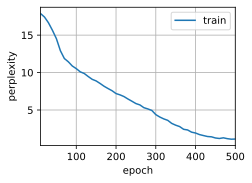

In [15]:
random.seed(0)
vocab_size, num_hiddens = len(vocab), 256
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, get_lstm_params, init_lstm_state, lstm)
params = model.init_params(rng)
params = train(model, params, train_iter, vocab, lr, num_epochs)